In [2]:
!pip3 install flair

     |████████████████████████████████| 143kB 2.4MB/s eta 0:00:01
  Created wheel for sqlitedict: filename=sqlitedict-1.6.0-cp36-none-any.whl size=14689 sha256=da937aa60da2c0f510fb9f4ea352abea88f283279eacea07ebc1699b46f88010
  Stored in directory: /tmp/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
  Created wheel for segtok: filename=segtok-1.5.7-cp36-none-any.whl size=23257 sha256=ee1ef7910c53fdde2704765a70435369a0154c1450bfad07842eb66cf01fff0f
  Stored in directory: /tmp/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
Successfully built sqlitedict segtok


In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

import torch
torch.cuda.is_available()

False

> ## Create a Corpus

### 1) Load from simple CSV file

In [3]:
from flair.datasets import CSVClassificationCorpus

ImportError: cannot import name 'CSVClassificationCorpus'

Great development..

### 2) FastText Format

In [4]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

In [5]:
FILE_PATH = "../input/bbctext/bbc-text.csv"
DATASET_FOLDER_PATH = "splitted_data"

column_name = {
    "text": "text",
    "label": "category"
}

# file format
__label__<label_1> <text>
__label__<label_1> __label__<label_2> <text>

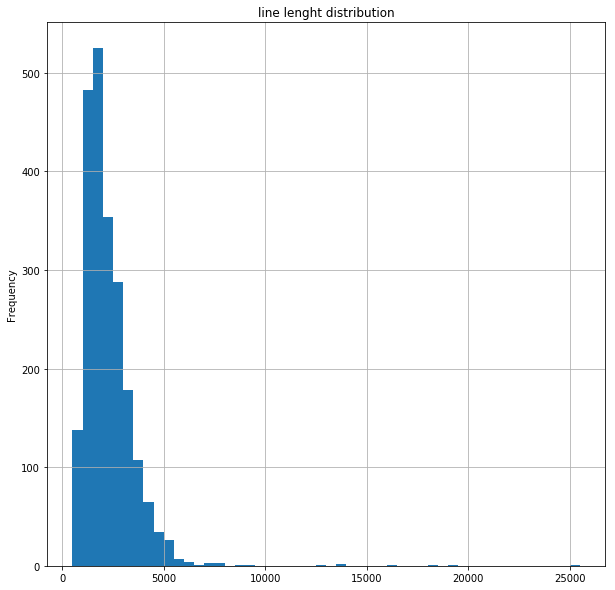

In [6]:
data_df = pd.read_csv(FILE_PATH).sample(frac=1)
data_df[column_name["label"]] = '__label__' + data_df[column_name["label"]].astype(str)

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

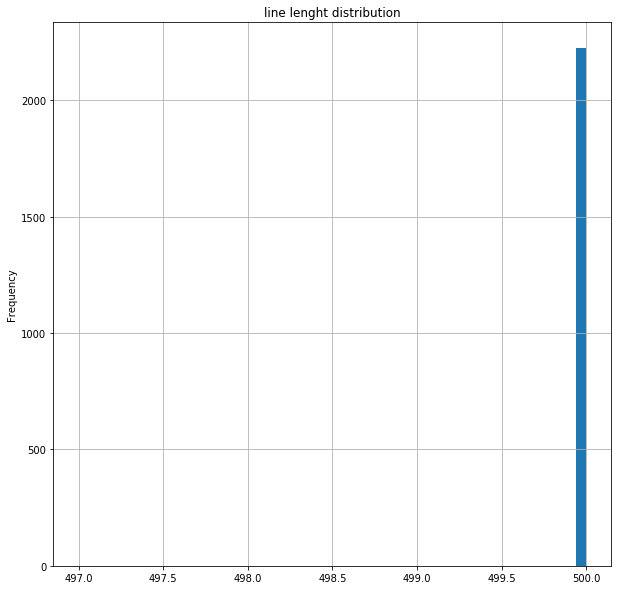

In [7]:
import re
from string import digits, punctuation

def clear_text(text, is_all_lower=True):
    punct = re.sub(r'[\.,!?&\-]', '', punctuation)
    punctuation_table = str.maketrans({key: "#" for key in punct})
    for char in ["\"", "\'"]:
        del punctuation_table[ord(char)]
    
    review_cleaned = text.apply(lambda x: re.sub(r'[^\x00-\x7F]', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r'[0-9]', '9', x))
    review_cleaned = review_cleaned.apply(lambda x: x.translate(punctuation_table))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' +', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' (?=[\.,!?&\-])','', x))
    
    if is_all_lower:
        review_cleaned = review_cleaned.str.lower()
        
    return review_cleaned

data_df[column_name["text"]] = clear_text(data_df["text"])
data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:500])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

In [8]:
if not os.path.exists(DATASET_FOLDER_PATH):
    os.makedirs(DATASET_FOLDER_PATH)
data_df.iloc[0: int(len(data_df)*0.8)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'train.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.8): int(len(data_df)*0.9)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'dev.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.9): ].to_csv(os.path.join(DATASET_FOLDER_PATH, 'test.csv'), sep='\t', index = False, header = False);

In [9]:
corpus = ClassificationCorpus(DATASET_FOLDER_PATH)

2019-08-10 17:59:07,502 Reading data from splitted_data
2019-08-10 17:59:07,508 Train: splitted_data/train.csv
2019-08-10 17:59:07,512 Dev: splitted_data/dev.csv
2019-08-10 17:59:07,513 Test: splitted_data/test.csv


Each line in a corpus is converted to a Sentence object annotated with the labels.

## Check distribution

In [10]:
train_df = pd.read_csv("splitted_data/train.csv", names=["label", "text"], delimiter="\t")
train_df.label.value_counts()

__label__sport            407
__label__business         402
__label__politics         341
__label__tech             325
__label__entertainment    305
Name: label, dtype: int64

In [11]:
val_df = pd.read_csv("splitted_data/dev.csv", names=["label", "text"], delimiter="\t")
val_df.label.value_counts()

__label__business         56
__label__sport            51
__label__entertainment    42
__label__politics         37
__label__tech             36
Name: label, dtype: int64

In [12]:
test_df = pd.read_csv("splitted_data/test.csv", names=["label", "text"], delimiter="\t")
test_df.label.value_counts()

__label__sport            53
__label__business         52
__label__tech             40
__label__politics         39
__label__entertainment    39
Name: label, dtype: int64

## Training a Model

> ## BERT

In [13]:
from flair.embeddings import BertEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric
# from flair.visual.training_curves import Plotter

In [3]:
MODEL_FOLDER_PATH = "model/BERT"
if not os.path.exists(MODEL_FOLDER_PATH):
    os.makedirs(MODEL_FOLDER_PATH)

In [16]:
params_train = {
    "flair_emb_forward": 'news-forward-fast',
    "flair_emb_backward": 'news-backward-fast',
    "hidden_size": 256,
    "reproject_words_dimension": 128,
    "max_epoch": 20,
    "evaluation_metric": EvaluationMetric.MICRO_ACCURACY
}

word_embeddings = [BertEmbeddings(), FlairEmbeddings(params_train["flair_emb_forward"]),
                   FlairEmbeddings(params_train["flair_emb_backward"])]

document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=params_train["hidden_size"],
                                            reproject_words=True, reproject_words_dimension=params_train["reproject_words_dimension"])

classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)

trainer = ModelTrainer(classifier, corpus)

100%|██████████| 407873900/407873900 [00:16<00:00, 25306887.00B/s]


2019-08-10 17:59:45,303 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmpuaavsyu3


100%|██████████| 19689779/19689779 [00:00<00:00, 36223695.77B/s]

2019-08-10 17:59:46,011 copying /tmp/tmpuaavsyu3 to cache at /tmp/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt
2019-08-10 17:59:46,044 removing temp file /tmp/tmpuaavsyu3


2019-08-10 17:59:52,953 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmpl1tm8_a1


100%|██████████| 19689779/19689779 [00:00<00:00, 41204693.41B/s]

2019-08-10 17:59:53,585 copying /tmp/tmpl1tm8_a1 to cache at /tmp/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt


2019-08-10 17:59:53,620 removing temp file /tmp/tmpl1tm8_a1
2019-08-10 17:59:58,717 {'politics', 'entertainment', 'business', 'sport', 'tech'}
2019-08-10 18:00:03,545 ----------------------------------------------------------------------------------------------------
2019-08-10 18:00:03,546 Evaluation method: MICRO_ACCURACY
2019-08-10 18:00:03,902 ----------------------------------------------------------------------------------------------------
2019-08-10 18:00:24,966 epoch 1 - iter 0/56 - loss 1.84763348
2019-08-10 18:02:00,381 epoch 1 - iter 5/56 - loss 1.94778440
2019-08-10 18:03:32,787 epoch 1 - iter 10/56 - loss 1.90704661
2019-08-10 18:05:13,114 epoch 1 - iter 15/56 - loss 1.81130447
2019-08-10 18:06:49,302 epoch 1 - iter 20/56 - loss 1.75702118
2019-08-10 18:08:25,907 epoch 1 - iter 25/56 - loss 1.68021062
2019-08-10 18:10:02,458 epoch 1 - iter 30/56 - loss 1.60633048
2019-08-10 18:11:41,070 epoch 1 - iter 35/56 - loss 1.56771400
2019-08-10 18:13:16,242 epoch 1 - iter 40/56 - 

{'test_score': 0.9058,
 'dev_score_history': [0.5045,
  0.7703,
  0.8243,
  0.8604,
  0.8468,
  0.8153,
  0.8829,
  0.9099,
  0.9324,
  0.8829,
  0.9189,
  0.9189,
  0.9099,
  0.9234,
  0.9234],
 'train_loss_history': [1.3248659723571368,
  0.7074815447309187,
  0.5092466953875763,
  0.35690437563295874,
  0.2428308693425996,
  0.20023302627461298,
  0.14520247029473207,
  0.13313921328101838,
  0.09001562717769827,
  0.0661603201213958,
  0.0652417667276625,
  0.02160377590917051,
  0.017558677970165654,
  0.009642486460506916,
  0.008613308837604043],
 'dev_loss_history': [tensor(1.2109, device='cuda:0'),
  tensor(0.5625, device='cuda:0'),
  tensor(0.4413, device='cuda:0'),
  tensor(0.4302, device='cuda:0'),
  tensor(0.4438, device='cuda:0'),
  tensor(0.5976, device='cuda:0'),
  tensor(0.3961, device='cuda:0'),
  tensor(0.3276, device='cuda:0'),
  tensor(0.3224, device='cuda:0'),
  tensor(0.4459, device='cuda:0'),
  tensor(0.3492, device='cuda:0'),
  tensor(0.3547, device='cuda:0'),


In [ ]:
learning_rate_tsv = trainer.find_learning_rate(MODEL_FOLDER_PATH, 'learning_rate.tsv')

plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

<img src="model/BERT/learning_rate.png" height=1000, width=1000>

In [ ]:
trainer.train(MODEL_FOLDER_PATH, max_epochs=params_train["max_epoch"], evaluation_metric=params_train["evaluation_metric"])

## Plot training curves

In [ ]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves(os.path.join(MODEL_FOLDER_PATH, 'loss.tsv'))
plotter.plot_weights(os.path.join(MODEL_FOLDER_PATH, 'weights.txt'))